In [1]:
import numpy as np
import astropy.io.fits as fits 
import matplotlib.pyplot as plt
from scipy import ndimage
import random
from scipy.optimize import leastsq
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from muse import *

In [2]:
hdu = fits.open('HE0232-0900.wo_absorption.fits')
#hdu.info()
qso_data = hdu[0].data
qso_error = hdu[1].data
qso_header = hdu[0].header
wavstart = qso_header['CRVAL3']
wavint = qso_header['CD3_3']
#wave = wavestart+np.arange(qso_data.shape[0])*wavint. This is the same as the one below. 
[central_x,central_y]= [67,51]#

In [3]:
mini_cube = qso_data[:,central_y - 7:central_y + 8,central_x - 7:central_x + 8]
mini_cube_error = qso_error[:,central_y - 7:central_y + 8,central_x - 7:central_x + 8]
qso_header['CRPIX1'] = qso_header['CRPIX1'] - (central_x - 7)
qso_header['CRPIX2'] = qso_header['CRPIX2'] - (central_y - 7)
new_hdu = fits.HDUList([fits.PrimaryHDU(mini_cube),fits.ImageHDU(mini_cube_error)])
new_hdu[0].header = qso_header
wave = np.arange(wavstart,(wavstart+(wavint*mini_cube.shape[0])),wavint)#start,stop,step

In [4]:
z =0.043143 
k = 1+z
mini_data = mini_cube
mini_error = mini_cube_error

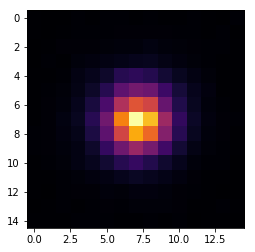

In [5]:
image1=mini_cube[0,:,:]
plt.imshow(image1,cmap='inferno')
plt.show()

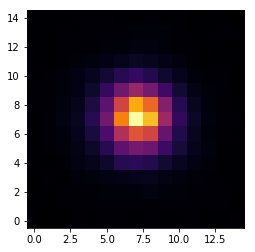

In [6]:
plt.imshow(image1,cmap='inferno',origin='lower',interpolation='nearest')
plt.show()

In [7]:
w80 = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
vel_diff = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
flux_narrow = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
flux_broad = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
flux_total = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
v5 = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)

In [10]:
np.seterr(divide='ignore', invalid='ignore')
for i in range(mini_data.shape[1]):
    for j in range(mini_data.shape[2]):
        spectrum = mini_data[:,i,j]
        wave = np.arange(wavstart,(wavstart+(wavint*mini_data.shape[0])),wavint)
        select = (wave > 4750*k) & (wave < 5090*k) 
        select1 = (spectrum> 0.08)
        n = len(wave[select])
        mean = sum(wave[select]*spectrum[select])/n
        sigma = sum(spectrum[select]*(wave[select]-mean)**2)/n  
        
        x = wave[select]
        y = spectrum[select]
        y_err = mini_error[:,i,j][select]
        
        spec_select = (y/y_err)>10
        popt2,pcov2 = leastsq(full_gauss2,x0=[2,40,12942,50.0,5,5,12842,100.0,5,1,12942,1000.0,1,1,12942,1000.0,-0.001,0.1],args=(x[spec_select],y[spec_select],y_err[spec_select]),maxfev=100000000)
                
        plt.plot(x[spec_select],y[spec_select])
        fit = full_gauss2(popt2,x[spec_select],y[spec_select],y_err[spec_select])*(y_err[spec_select])+y[spec_select]
        plt.plot(x[spec_select],fit,'r-',label='fit')
        plt.show()
                
        (amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c)=popt2
        cor_popt2 = np.array([amp_OIII5007,amp_OIII5007_br,vel_OIII,vel_sigma_OIII,vel_OIII_br,vel_sigma_OIII_br])
                
        c = 3*(10**5)
        (wav_min,wav_max)=(4967*k,5037*k)
        wave = np.arange(wav_min,wav_max,0.02) 
        cumsum = np.cumsum(OIII_wo_cont(wave,*cor_popt2))
        norm_sum=cumsum/cumsum[-1]
    
        select = (norm_sum>0.1) & (norm_sum<0.9)
        w80_spec = wave[select][-1]-wave[select][0]
                
        select =  (norm_sum>0.05) & (norm_sum<0.5)
        v5_spec = wave[select][0]-wave[select][-1]

        w80[i,j]=((w80_spec)/5006.8)*(c/(1+z))
        v5[i,j] = ((v5_spec)/5006.8)*(c/(1+z))
                
                #plt.legend
                #F_total = (2.507*(cor_popt2[0]*cor_popt2[4]) + 2.507*(cor_popt2[1]*cor_popt2[5]))*(10**-16)
                #flux_total[i,j] =  F_total
                #F_narrow = 2.507*(cor_popt2[0]*cor_popt2[4])*(10**-16)
                #F_broad = 2.507*(cor_popt2[1]*cor_popt2[5])*(10**-16)
        velshift_angstrom = (cor_popt2[2]-cor_popt2[3])
                #print cor_popt2[3]
        velshift_actual = (velshift_angstrom)/(cor_popt2[3])*(c/(1+z)) 
        vel_diff[i,j] = velshift_actual/100000 
        print('velocity shift is', vel_diff[i,j])

TypeError: Improper input: N=18 must not exceed M=10

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib import cm
cmap=cm.gray
plt.imshow(w80,origin='lower',interpolation='nearest', cmap='gray', norm=LogNorm())
cbar = plt.colorbar()
plt.show()

#plt.savefig('w80_fig.png',format='png')

In [ ]:
fig = plt.figure()

cmap = cm.plasma
cmap.set_bad('white',1)

frame = plt.imshow(w80, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label(r"w80")

In [ ]:
plt.imshow(vel_diff,origin='lower',interpolation='nearest',cmap='gray')
cbar = plt.colorbar()
cmap.set_bad('white',1)
plt.show()

In [ ]:
fig = plt.figure()

cmap = cm.RdBu
cmap.set_bad('white',1)

frame = plt.imshow(vel_diff, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label(r"velocity shift")

In [ ]:
w80_hdu = fits.PrimaryHDU(data=w80)
w80_hdu.writeto('w80_myfit.fits',clobber=True)

In [ ]:
plt.imshow(v5,origin='lower',interpolation='nearest',cmap='gray', norm=LogNorm())
cbar = plt.colorbar()
plt.show()

In [ ]:
plt.imshow(flux_total,origin='lower',interpolation='nearest',cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
plt.show()

In [ ]:
vel_diff_hdu = fits.PrimaryHDU(data=vel_diff)
vel_diff_hdu.writeto('vel_diff_myfit.fits',clobber=True)

In [ ]:
flux_total_hdu = fits.PrimaryHDU(data=flux_total)
flux_total_hdu.writeto('flux_total_myfit.fits',clobber=True)

In [ ]:
Flux= np.sum(flux_total)
Flux

In [ ]:
D_L = 7.31*(10**26)
L_total = 31.5*((D_L)**2)*(Flux)/(2.507)
L_total

In [ ]:
velocity_shift = velshift_actual/100000
velocity_shift

In [ ]:
v5_final = v5_spec
v5_final

In [ ]:
velocity_dispersion = w80_final/3.29
velocity_dispersion

In [ ]:
from scipy import math
math.log10(L_total)

In [ ]:
np.max(w80)